# Elastic weight consolidation - new behaviour

In the past notebook *Triplet learning for bearing fault classification* we trained a classification model for bearing faults of rotating equipment. Such model was robust to different operating conditions such as different machine loads or rotation velocity, and did not use characteristic information about the machine, such as the rotation velocity or the characteristic coefficients. We used an approach based on triplet learning.

In this notebook, we want to illustrate how the retraining process would be done, when new data (from the same machine) arribes. Such new data may be slightly different from the data previously seen by the model, either because of concept drift or simply because we are seeing a common behaviour which had not been seen before. Therefore, we want the model to learn useful information of this new data without forgetting about the previously acquired knowledge.

In this notebook we will simulate the arrival of new unseen behaviour, with little change, and see how the model adapts to this new situation. In the notebook *Elastic weight consolidation - concept drift* we simulate the other situation, concept drift. In order to simulate this new behaviour we will use two these two datasets:

+ **Case Western Reserve University Bearing Data Center - without noise**: This dataset contains vibration data (waveforms) of different bearings, each suffering from a fault (inner ring, outer ring) or being healthy. The fault is completely developed. This dataset will be considered as the *old* dataset.

+ **Case Western Reserve University Bearing Data Center - with noise**: It is the same dataset as the *old* one, but we have included some (non-white) noise. We will use this data as the *new* data that the model has to learn.

The inputs of the models will be the same as in the notebook *Triplet learning for bearing fault classification*.

More details about the training process are provided in the following sections.


The following lines of code are used to mount to drive account and import the needed packages.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
import scipy.io
import scipy.signal

import plotly
from plotly.graph_objs import graph_objs as go
from plotly.offline import iplot

from sklearn.metrics import confusion_matrix, accuracy_score


import keras
import tensorflow as tf
from tensorflow.keras import Model, layers

import pandas as pd
import umap
import sys

sys.path.append('./Training')
sys.path.append('./Data')
sys.path.append('./Models')
sys.path.append('./Load_Data')
sys.path.append('./Preprocessing')

from CWRU_data import Preprocessing_CWRU, Load_CWRU_noise, Load_CWRU
from envelope import envl_freq
from CNN_model import Embedding, Classification
from train_classifier import Training_classifier
from train_embeddings import Train_Embeddings
from pretraining import Pretraining
from EWC import Train_Classifier_EWC, Train_Embeddings_EWC,Fisher_matrix

In [2]:
print(tf.__version__)

2.1.0


## Datasets

We upload two types of data. The first one is noiseless.
The second one has noise.

The noise is introduced in two different ways:

1. Amplify the apmplitude of the 4rth first harmonics.

2. Introduce white noise (random frequencies) within a frequency band of 750-1000Hz.

## Preprocessing

In order to preprocess data we performed the following steps:

+ Downsampling from 20000 Hz to 5000 Hz in order to have data more similiar to the real productio data.

+ Rolling window for each waveform, to reduce the size of the wavevorm to 1000 timestamps (instead of 5000) and to obtain more samples from the same waveform. There is no overlap.

+ Adaptative normalization: minmax scaling.

+ Shuffle samples.

+ Split of training and test sets.

## Load Case Western Reserve University (CWRU) Data

Given the file names of the data, the following class imports and processes the data in order to make it suitable for the CNN model. 

The datasets are stored in Matlab files. There are three bearing failure modes: healthy, inner ring and outer ring. For each failure, there are four different loads, running at different rotation speed: 1797, 1772, 1750 and 1730 rpm. Finally, for each load there are two different diameter failures (7mm and 14mm). We will mix all the failures, loads and diameters. 

In [3]:
prep = Preprocessing_CWRU()

CWRU_noise = Load_CWRU_noise(prep)

X_train_noise, X_test_noise, y_train_noise, y_test_noise, load_train_noise, load_test_noise = CWRU_noise.get_X_y()

C:\Users\laia.domingo.colomer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Noiseless CWRU Data

In [4]:
CWRU = Load_CWRU(prep)

X_train, X_test, y_train, y_test, load_train, load_test = CWRU.get_X_y()

## Visualizing the noise

We have created two datasets: CWRU with and without noise. In the following code, we will give an example to show what the noise looks like, both in the time (waveform) and frequency (spectrum) domain.

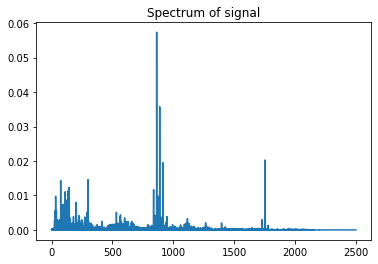

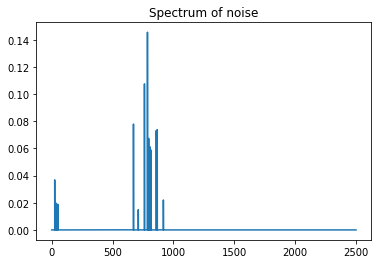

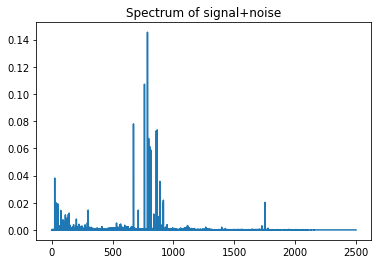

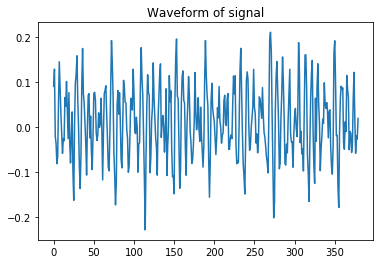

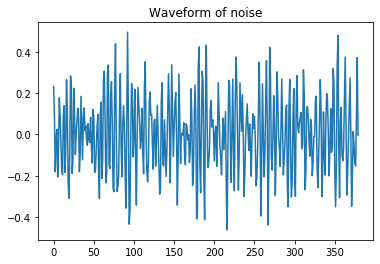

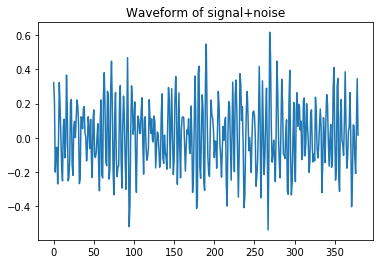

In [6]:
#Prepare the data
normal0_raw = scipy.io.loadmat('Data/CWRU/D7/Normal/97.mat')['X097_DE_time'].reshape(1,-1)[0]
normal0_raw = scipy.signal.decimate(normal0_raw,2)

data = np.copy(normal0_raw)
env = envl_freq(5000, 1800, 2400)

#Prepare the noise and added noise
noise = np.zeros(data.shape)
noise = prep.add_noise_harmonics(noise,1797)
noise = prep.add_noise_band(noise,300000,20000,0,0.08,10,4.0)
data_noise = data + noise

#Show plots

#Spectrum of signal
fft_env, freqs_env, _ = env.acc_spectrum(data, len(data), 5000, cutoff_freq=1)
plt.title('Spectrum of signal')
plt.plot(freqs_env, fft_env)
plt.show()

#Spectrum of noise
fft_noise, freqs_noise, _ = env.acc_spectrum(noise, len(noise), 5000, cutoff_freq=1)
plt.plot(freqs_noise, fft_noise)
plt.title('Spectrum of noise')
plt.show()

#Spectrum of signal+noise
fft_env, freqs_env, _ = env.acc_spectrum(data_noise, len(data_noise), 5000, cutoff_freq=1)
plt.title('Spectrum of signal+noise')
plt.plot(freqs_env, fft_env)
plt.show()

#Waveform of signal
plt.plot(range(len(data[range(100,2000,5)])),data[range(100,2000,5)])
plt.title('Waveform of signal')
plt.show()

#Waveform of noise
plt.plot(range(len(noise[range(100,2000,5)])),noise[range(100,2000,5)])
plt.title('Waveform of noise')
plt.show()

#Waveform of signal+noise
plt.plot(range(len(data_noise[range(100,2000,5)])),data_noise[range(100,2000,5)])
plt.title('Waveform of signal+noise')
plt.show()


This is the code to load the embedding and classification models from the path where the weights are saved.

In [7]:
def load_model(filepath, learning_rate = 0.001, net = 'classification'):
    """
    Loads the embedding and classification models.
    Args:
        filepath (str): Path of the saved weights
        learning_rate (float): Learning rate of the Adam optimizer
    Returns:
        embedding (Model): Embedding model
        classification (Model): Classification model
    """
    #Redefine model
    embedding = Embedding()
    classification = Classification(embedding)

    optimizer = tf.optimizers.Adam(learning_rate)
    if net=='classification':
        ckpt = tf.train.Checkpoint(optimizer=optimizer, net=classification)
        manager = tf.train.CheckpointManager(ckpt, directory = filepath , max_to_keep=3)
        ckpt.restore(manager.latest_checkpoint)
        embedding = classification.embedding
    else:
        ckpt = tf.train.Checkpoint(optimizer=optimizer, net=embedding)
        manager = tf.train.CheckpointManager(ckpt, directory = filepath , max_to_keep=3)
        ckpt.restore(manager.latest_checkpoint)
        
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")

    return embedding, classification

# Example of use:
# embedding, classification = load_model("Weights/TL/classifier/training/", learning_rate = 0.0001 )

## Pretraining: Simple CNN

We start by pre training the CNN with cross entropy loss, because it is a very stable loss function. This pre trained model will be used later to train the embeddings and the final classification model. 

We first define the hyperparameters: learning rate, training iterations, batch size, input size of the CNN, number of classification outputs.


In [8]:
# Parameters
learning_rate = 0.001
training_iters = 500
batch_size = 16
display_step = 10
filepath = "Weights/EWC/CWRU-noise/classifier/pretraining/"

# Network Parameters
n_input = 1000 # Length of input data
num_classes = 4  # number of classes


### Embeddings

Next, we define the structure of the embedding network:

It consists of a 1D neural network, with the input the temporal series (waveform). 

The CNN has 3 1D Convolutional layers with 32,32 and 64 filters respectively, height=10, strides=4 and padding='same'. We have 3 MaxPooling subsampling layers with pool size = 10, strides = 4. Then we have 2 FC with 32 nodes, and another with 20 output nodes. This last layer is the output of the embedding- All layers have Relu activation function. This embedding will be used later on to classify the faults into different faults.

### Classification model

The classification model takes as input the output of the embedding model, and adds 3 Fc layers, with 64, 64 and 32 filters each. The output is the number of types of defects (4). During the pretraining process, all layers will be trained using cross entropy loss.

You can skip the next cell and load directly the saved weights. 

In [9]:
# Build neural network model.
embedding = Embedding()
conv_net = Classification(embedding)

pretrain = Pretraining(conv_net, learning_rate, training_iters, batch_size, display_step,filepath, restore=False)

pretrain.fit( X_train, y_train)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

step: 10, loss: 1.242955, accuracy: 0.437500
step: 20, loss: 1.116450, accuracy: 0.750000
step: 30, loss: 0.934655, accuracy: 0.812500
step: 40, loss: 0.938980, accuracy: 0.750000
step: 50, loss: 0.803170, accuracy: 1.000000
step: 60, loss: 0.816710, accuracy: 0.937500
step: 70, loss: 0.772234, accuracy: 1.000000
step: 80, loss: 0.808047, accuracy: 0.937500
step: 90, loss: 0.796488, accuracy: 0.937500
step: 100, loss: 0.754763, accuracy: 1.000000
step: 110, loss: 0.784848, accuracy: 1.000000
step: 120, 

In [12]:
# Comment this line to use the model you just trained, and not the loaded weights
embedding, conv_net = load_model("Weights/EWC/CWRU-noise/classifier/pretraining/")

# Test model on validation set.
pred= conv_net(X_test)
emb = embedding(X_test)
y_pred = np.argmax(pred.numpy(), axis=1)
print("Test Accuracy: %f" % accuracy_score(y_pred, y_test))

Restored from Weights/EWC/CWRU-noise/classifier/pretraining/ckpt-1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by pass

## Triplet loss

Here we define the functions that will be used to compute the triplet loss of the embeddings. We use online triplet mining, with both 'batch all' and 'batch hard' strategies. 

For more information about triplet loss, refer to the notebook *Triplet learning for bearing fault classification*.



## Training Triplet loss

Now that we have a good initialization for the Weights from the pretrained model, we perform triplet loss optimization of the embeddings. 

We first define the hyperparameters for this part: learning rate, training iterations, batch size, margin, triplet strategy, embedding size and input size.  

You can skip these three cells and load directly the saved weights. 

In [17]:
# Parameters
learning_rate = 0.0001
training_iters = 15
batch_size = 64

#Triplet parameters
margin = 1.0
squared=False
triplet_strategy='batch_hard'  #'batch_all'
filepath = "Weights/EWC/CWRU-noise/embedding"

# Network Parameters
n_input = 1000 # Length of input data
embedding_size = 20 # length of embedding features 


In [18]:
#Function to get batches
def get_all_batches(data,labels,batch_size):
  '''
  Gets all the batches from existing dataset.

  Args:
    data (numpy array): X data
    labels (numpy array): y data
    batch_size (int): Batch size

  Returns:
    batches_x (list of numpy array): list of batches for X data
    batches_y (list of numpy array): list of batches for y data
    num_batches (int): Number of batches
  '''
  idx = np.arange(0,data.shape[0])
  np.random.shuffle(idx)

  data_shuffle = data[idx,:]
  labels_shuffle = labels[idx]

  labels_shuffle = labels_shuffle[0:labels.shape[0] - labels.shape[0]%batch_size]
  data_shuffle = data_shuffle[0:labels.shape[0] - labels.shape[0]%batch_size,:]
  
  num_batches = data_shuffle.shape[0]/batch_size 
  batches_x =np.split(data_shuffle,num_batches)
  batches_y =np.split(labels_shuffle,num_batches)

  return batches_x,batches_y,num_batches


We train the embeddings using triplet loss.

In [19]:
# Build neural network model.
_,_,num_batches = get_all_batches(X_train,y_train,batch_size)
print(num_batches*training_iters)

train_emb = Train_Embeddings( embedding, learning_rate, int(num_batches*training_iters), 
                             batch_size, display_step, triplet_strategy, margin,
                             squared, filepath, restore = False)

train_emb.fit(X_train, y_train)

315.0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: LIVE_VARS_IN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Li

In [20]:
# Comment this line to use the model you just trained, and not the loaded weights
embedding, conv_net = load_model("Weights/EWC/CWRU-noise/embedding", net ="emb")

emb2 = embedding(X_test)


Restored from Weights/EWC/CWRU-noise/embedding\ckpt-1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



We visualize the embeddings using UMAP

C:\Users\laia.domingo.colomer\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)



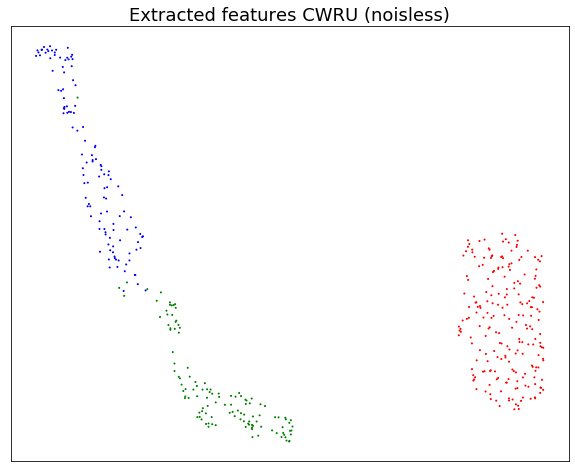

In [25]:
features = emb2

embed= umap.UMAP(n_neighbors=10,
                      min_dist=0.2,
                      metric='correlation').fit_transform(features)

color = pd.DataFrame(y_test,columns=['color'])
color.replace({0:'red', 1:'blue', 2:'green', 3:'orange'},inplace=True)


fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(embed[:,0], embed[:,1], 
            c=color.values.flatten(),
            cmap="Spectral", 
            s=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Extracted features CWRU (noisless)", fontsize=18)

plt.show()


We can see that the embeddings are far apart for different failures, and close together for the same failure.

We visualize also the embeddings for the second task (noisy data).

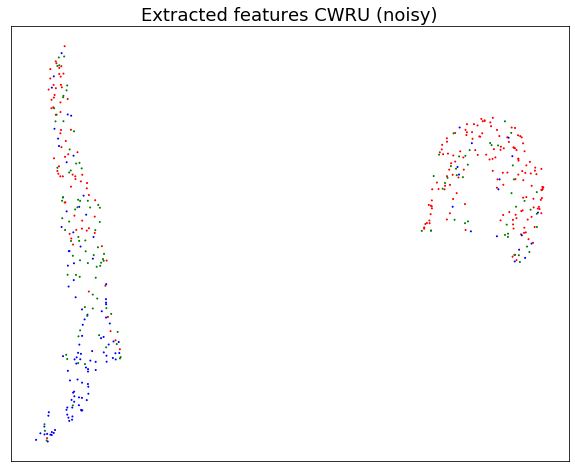

In [26]:
emb = embedding(X_test_noise)

features = emb

embed= umap.UMAP(n_neighbors=10,
                      min_dist=0.2,
                      metric='correlation').fit_transform(features)

color = pd.DataFrame(y_test_noise,columns=['color'])
color.replace({0:'red', 1:'blue', 2:'green', 3:'orange'},inplace=True)


fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(embed[:,0], embed[:,1], 
            c=color.values.flatten(),
            cmap="Spectral", 
            s=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Extracted features CWRU (noisy)", fontsize=18)

plt.show()


## Classification model using triplet loss embeddings

Now that we have trained the embeddings using triplet loss, we will train the classifier using cross entropy loss. During this training the embedding layers will be frozen.



In [27]:
#Parameters
num_classes = 4
batch_size= 64
training_iters = 200
learning_rate=0.001
filepath = "Weights/EWC/CWRU-noise/classifier/training"

In [28]:
# Build neural network model.

classifier = Training_classifier(conv_net, learning_rate, training_iters, 
                                 batch_size, display_step, filepath, restore=False)

classifier.fit( X_train, y_train)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

step: 10, loss: 1.025661, accuracy: 0.781250
step: 20, loss: 0.977135, accuracy: 0.781250
step: 30, loss: 0.975504, accuracy: 1.000000
step: 40, loss: 0.943703, accuracy: 1.000000
step: 50, loss: 0.954870, accuracy: 0.890625
step: 60, loss: 0.893557, accuracy: 0.906250
step: 70, loss: 0.920396, accuracy: 0.968750
step: 80, loss: 0.902006, accuracy: 0.984375
step: 90, loss: 0.858667, accuracy: 1.000000
step: 100, loss: 0.834314, accuracy: 1.000000
step: 110, loss: 0.852035, accuracy: 0.937500
step: 120, 

We check the final accuracy

In [29]:
# Comment this line to use the model you just trained, and not the loaded weights
embedding, conv_net = load_model("Weights/EWC/CWRU-noise/classifier/training")

# Test model on test set.
pred= conv_net(X_test)
y_pred = np.argmax(pred.numpy(), axis=1)
print("Test Accuracy: %f" % accuracy_score(y_pred, y_test))

Restored from Weights/EWC/CWRU-noise/classifier/training\ckpt-1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test Accuracy: 0.984716


In [30]:
confusion_matrix(y_test, y_pred)

array([[214,   0,   0],
       [  0, 116,   6],
       [  0,   1, 121]], dtype=int64)

Now we test the accuracy on the noisy data

In [31]:
# Test model on test set.
pred= conv_net(X_test_noise)
y_pred = np.argmax(pred.numpy(), axis=1)
print("Test Accuracy: %f" % accuracy_score(y_pred, y_test_noise))

Test Accuracy: 0.469432


We notice that the model has a bad accuracy for noisy data. 
If this data is thought as a new behaviour that can happen, we want the model to capture both behaviours. For this reason, we will try Elastic weight consolidation approach.

## Elastic Weight Consolidation

The goal of this technique is to train a model to perform task B without forgetting about task A. In order to do so, we will add a weighted L2 regularization. For more information about EWC refer to the notebook * Elastic weight consolidation- concept drift* or to the Master Thesis pdf.

### Fisher information matrix for triplet loss

First we create a class that calculates the fisher matrix for an existing model.
We will define the two fisher matrices: for the embeddings (triplet loss) and the classifier (cross entropy loss). 

The fisher information matrix for the embeddings is a bit tricky, since we do not have a loss function for every sample of the dataset, but for every hard/semi-hard triplet. In order to speed up the computations, we will use the batch hard strategy to compute the loss for every hard triplet. We will sample a batch, calculate the hard loss for all the elements of the batch, slice the tensor to get the $ith$ element, calculate its loss function,get the gradients and append the square gradients to a list. 

Now we calculate the fisher information matrix for both the embeddings (triplet loss) and the classifier (cross entropy loss).

You can skip all these cells (until the validation). The training of EWC may take some hours to finish.

In [0]:
#Triplet loss fisher matrix
conv_net.unfreeze()
fisher_matrix_TL =  Fisher_matrix(X_train, y_train, embedding, task = 'triplet loss', batch_size = 32,
                     triplet_strategy=triplet_strategy, margin=margin, squared = squared)

In [0]:
#Cross entropy loss fisher matrix
conv_net.freeze()
fisher_matrix_CL =  Fisher_matrix(X_train, y_train, conv_net, task = 'classsification')

Now we will train the embeddings with triplet loss and EWC and then the classifier with cross entropy and EWC.

## Triplet loss + EWC

In [0]:
training_iters = 500
display_step=1
learning_rate = 0.0001
filepath ="Weights/EWC/CWRU-noise/fisher/embedding"
lamb = 1000
int(num_batches*training_iters)

10500

In [0]:
conv_net.unfreeze()

train_emb_EWC = Train_Embeddings_EWC(embedding, fisher_matrix_TL , learning_rate, int(num_batches*training_iters),
                                     batch_size, display_step, "batch_all", margin, squared,lamb, filepath, restore=False)

idx = np.random.choice(X_train.shape[0], 500)
train_emb_EWC.fit(X_train_noise, y_train_noise, X_train[idx,:], y_train[idx], save = False)

step 1 loss 1.42552459 fisher_loss 0.0196445528 triplet loss 1.40588009 l2_loss 0.000499920163 fraction B 0.688044906 lossA 0.427129418 fraction A 0.00572607806
step 2 loss 1.33377302 fisher_loss 0.0137187103 triplet loss 1.32005429 l2_loss 0.00153635326 fraction B 0.714368463 lossA 0.413604081 fraction A 0.00585347507
step 3 loss 1.24886084 fisher_loss 0.024279831 triplet loss 1.224581 l2_loss 0.00305564608 fraction B 0.732956171 lossA 0.413766086 fraction A 0.00583338458
step 4 loss 1.40245092 fisher_loss 0.0288779829 triplet loss 1.37357295 l2_loss 0.00479458692 fraction B 0.718847394 lossA 0.408234298 fraction A 0.0060989568
step 5 loss 1.25356853 fisher_loss 0.0326572023 triplet loss 1.22091138 l2_loss 0.00705654547 fraction B 0.642805576 lossA 0.400211036 fraction A 0.00577447051
step 6 loss 1.3043083 fisher_loss 0.0374396183 triplet loss 1.26686871 l2_loss 0.00941510685 fraction B 0.711723566 lossA 0.397972941 fraction A 0.00569004
step 7 loss 1.27462244 fisher_loss 0.0455957502

#Classifier EWC

Now try to train the classifier using EWC (without training the embeddings)

In [0]:
training_iters = 20000
learning_rate = 0.0001
filepath ="Weights/EWC/CWRU-noise/fisher/classifier/"
int(num_batches*training_iters)

420000

In [0]:
conv_net.freeze()
train_clas_EWC = Train_Classifier_EWC(conv_net,fisher_matrix_CL, learning_rate, int(num_batches*training_iters),
                                     batch_size, display_step,5e3, filepath, restore=False)

train_clas_EWC.fit(X_train_noise, y_train_noise, X_train, y_train, save=False)

step 16 loss 0.161784232 fisher_loss 0.0513590239 l2_loss 0.0119169448 accuracy B 0.924612 accuracy A 0.96008867
step 32 loss 0.350608528 fisher_loss 0.0551934727 l2_loss 0.0290297065 accuracy B 0.926829278 accuracy A 0.954175889
step 48 loss 0.330241919 fisher_loss 0.0572124608 l2_loss 0.0472856909 accuracy B 0.931263864 accuracy A 0.952697694
step 64 loss 0.38424629 fisher_loss 0.0544444434 l2_loss 0.0648033321 accuracy B 0.932002962 accuracy A 0.951958597
step 80 loss 0.130845815 fisher_loss 0.062874347 l2_loss 0.0887026116 accuracy B 0.936437547 accuracy A 0.947524
step 96 loss 0.274997801 fisher_loss 0.0491293445 l2_loss 0.104643837 accuracy B 0.931263864 accuracy A 0.953436792
step 112 loss 0.196266413 fisher_loss 0.0528281368 l2_loss 0.127509475 accuracy B 0.933481157 accuracy A 0.949741304
step 128 loss 0.395174861 fisher_loss 0.0617439859 l2_loss 0.157425985 accuracy B 0.940133035 accuracy A 0.936437547
step 144 loss 0.120064408 fisher_loss 0.0636834577 l2_loss 0.197223768 acc

### Accuracy after EWC

In [32]:
# Comment this line to use the model you just trained, and not the loaded weights
embedding, conv_net = load_model("Weights/EWC/CWRU-noise/fisher/classifier/")

# Test model on test set.
pred= conv_net(X_test)
y_pred = np.argmax(pred.numpy(), axis=1)
print("Test Accuracy: %f" % accuracy_score(y_pred, y_test))

Restored from Weights/EWC/CWRU-noise/fisher/classifier/ckpt-1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test Accuracy: 0.951965


In [33]:
# Test model on test set.
pred= conv_net(X_test_noise)
print("Test Accuracy: %f" % accuracy_score(y_pred, y_test_noise))

Test Accuracy: 0.951965


Finally, we visualize the embeddings for both datasets.

### Task A (CWRU without noise)

In [34]:
emb = np.nan_to_num(embedding(X_test))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



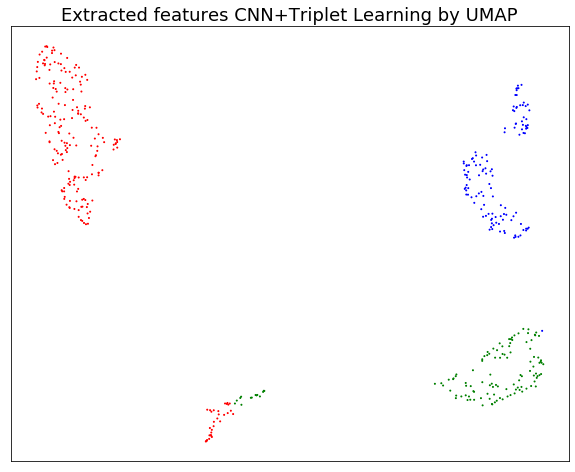

In [39]:
features = emb

embed = umap.UMAP(n_neighbors=10,
                      min_dist=0.2,
                      metric='correlation').fit_transform(features)

color = pd.DataFrame(y_test, columns=['color'])
color.replace({0:'red', 1:'blue', 2:'green', 3:'orange'},inplace=True)


fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(embed[:,0], embed[:,1], 
            c=color.values.flatten(),
            cmap="Spectral", 
            s=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Extracted features CNN+Triplet Learning by UMAP", fontsize=18)

plt.show()


### Task B (CWRU with noise)

In [36]:
emb_noise = np.nan_to_num(embedding(X_test_noise))

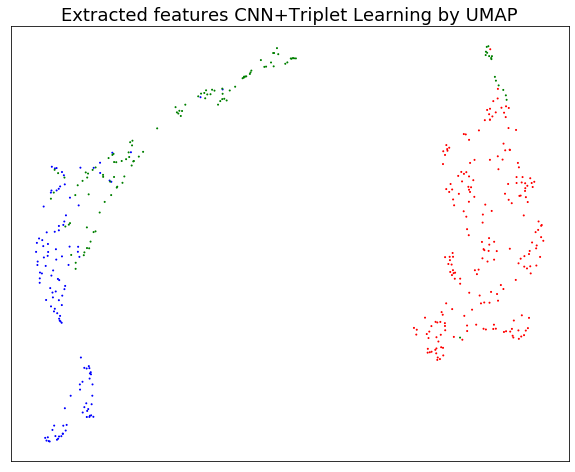

In [38]:
features = emb_noise

embed = umap.UMAP(n_neighbors=10,
                      min_dist=0.2,
                      metric='correlation').fit_transform(features)

color = pd.DataFrame(y_test_noise,columns=['color'])
color.replace({0:'red', 1:'blue', 2:'green', 3:'orange'},inplace=True)


fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(embed[:,0], embed[:,1], 
            c=color.values.flatten(),
            cmap="Spectral", 
            s=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Extracted features CNN+Triplet Learning by UMAP", fontsize=18)

plt.show()


Here we add the code needed to import this final model